In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc 

ds_ws = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ua850_v2c_185101-201412.nc")
ds_pressure = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ps_v2c_185101-201412.nc")

#the chosen grid point is [time, 0, 13, 120] -> [time, 850.0, 51.6 N, 337.5 E]
#to access year use .dt.year
#print(type(ds_ua850.time[1].dt.year))
local_speed = np.array([])
for i in range(10, 164): #February, 2014 is 1957
    local_speed = np.append(local_speed, [np.average([float(ds_ws.ua[12*i-1, 0, 13, 120]), \
                                         float(ds_ws.ua[12*i, 0, 13, 120]), \
                                       float(ds_ws.ua[12*i+1, 0, 13, 120])])])
    
plt.plot(ds_ws.time[120:1957:12].dt.year, local_speed)
plt.title('Time series of observed ua_850 at 51.6N and 337.5E')
plt.ylabel('Mean winter wind speed (m/s)')
plt.xlabel('Year')
plt.show()

'''Filling in the unfilled coordinates''' 
#Creating equally spaced longitude array that includes real coordinates
lonss = np.empty([128*25])
for i in range(0, 128):
    if i == 127:
        lonss[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], 360.0, 26)[0:-1] #interpolating up to 360
    else:
        lonss[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], ds_ws.lon[i+1], 26)[0:-1]

#Creating equally spaced latitude array that includes real coordinates
latss = np.empty([31*25])
for i in range(0, 31):
    latss[(i*25):(i+1)*25] = np.linspace(ds_ws.lat[i], ds_ws.lat[i+1], 26)[0:-1]
latss = np.append(latss, ds_ws.lat[31])

#latss 65.68921234 - iceland
#lonss 341.8875 - iceland
#latss 37.78471054 - azores
#lonss 334.35 - azores 
latss = np.round(latss, 8)
print(np.where(latss == 65.68921234), np.where(lonss == 341.8875), 'Iceland')
print(np.where(latss == 37.78471054), np.where(lonss == 334.35), 'Azores')


<Figure size 640x480 with 1 Axes>

((array([199]),), (array([3039]),), 'Iceland')
((array([449]),), (array([2972]),), 'Azores')


(3200, 776, (776, 3200))


<a list of 13 text.Text objects>

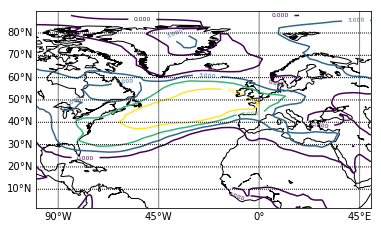

In [4]:
import os
os.environ["PROJ_LIB"] = "/rds/general/user/ib719/home/anaconda3/envs/test1/share/proj"
from mpl_toolkits.basemap import Basemap
ds_ua850 = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated.nc")

map = Basemap(projection='cyl',llcrnrlon=-100.,llcrnrlat=1.39,urcrnrlon=50.0,urcrnrlat=90.,resolution='c') 
#map = Basemap(projection='cyl',llcrnrlon=-180.,llcrnrlat=1.39,urcrnrlon=180.0,urcrnrlat=90.,resolution='c') 
# projection, lat/lon extents and resolution of polygons to draw
# resolutions: c - crude, l - low, i - intermediate, h - high, f - full
map.drawcoastlines()
map.drawparallels(np.arange(10, 81, 10), labels = [1,0,0,0])
map.drawmeridians(np.arange(-90, 46, 45), labels = [0,0,0,1])
ua = np.array(ds_ua850.value[2])
#ua = np.transpose(np.array(ua))
clevs = np.arange(0, 10, 3)
print(len(lonss), len(latss), ua.shape)

x, y = np.meshgrid(lonss, latss)
#cs = map.contour(x, y, np.roll(ua[:, :], shift = -1600, axis = 1), clevs, colour = 'b')
cs = map.contour(x, y, ua[:, :], clevs, colour = 'b', latlon = 1)
#print(lonss-180)

#x, y = np.meshgrid(ds_ws.lon[:], ds_ws.lat[:])
#cs = map.contour(x, y, ds_ws.ua[0, 0, :, :], clevs, colour = 'b', latlon = 1)

#arr = np.random.random((7,4))
#clevs2 = np.array([0.1, 0.3, 0.5])
#x, y = np.meshgrid(np.array([300.0, 301.0, 302.0, 303.0]), np.array([10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]))
#cs = map.contour(x-180, y, arr[:, :], clevs2, colour = 'b', latlon = 1)
plt.clabel(cs, fontsize=6, inline=2)

In [11]:
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 
 
'''Creating a new windspeed file'''
start_time = tm.time()
old_lons = np.append(np.array(ds_ws.lon[:]), 360.0) #interpolating up to 360

path = "/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc"
ds_ua850 = nc.Dataset(path, 'w', format = 'NETCDF4')
time = ds_ua850.createDimension('time', 1968)
lat = ds_ua850.createDimension('lat', 31*25+1)
lon = ds_ua850.createDimension('lon', 128)

times = ds_ua850.createVariable('time', np.float32, ('time',))
lats = ds_ua850.createVariable('lat', np.float32, ('lat',))
lons = ds_ua850.createVariable('lon', np.float32, ('lon',))
value = ds_ua850.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = np.array(ds_ws.time)
lons[:] = np.array(ds_ws.lon)
lats[:] = latss

for i in range(0,1968):
    ds = ds_ws.isel(time=i).isel(level=0)
    values = ds.ua
    value[i,:,:] = sp.interpolate.griddata(np.array(ds_ws.lat), values, latss , method='cubic')

ds_ua850.close()

print("Total time: --- %s seconds ---" % (tm.time() - start_time))

Total time: --- 59.8579838276 seconds ---


In [18]:
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

start_time = tm.time()
vals = np.empty([1968, 3, 3])

path_ic = "/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc"
ps_ic = nc.Dataset(path_ic, 'w', format = 'NETCDF4')
time = ps_ic.createDimension('time', 1968)
lat = ps_ic.createDimension('lat', 776)
lon = ps_ic.createDimension('lon', 128)

times = ps_ic.createVariable('time', np.float32, ('time',))
lats = ps_ic.createVariable('lat', np.float32, ('lat',))
lons = ps_ic.createVariable('lon', np.float32, ('lon',))
value = ps_ic.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = ds_pressure.time[:]
lats[:] = latss
lons[:] = ds_pressure.lon[:]

'''Interpolating surface pressure'''
for i in range(0,1968):
    ds = ds_pressure.isel(time=i)
    values = ds.ps
    value[i,:,:] = sp.interpolate.griddata(ds_ws.lat[:], values, latss[:] , method='cubic')

ps_ic.close()

In [29]:
i = 40
ps_new = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")
ps_iceland = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")

#print(ps_new.lat[440:500])
azores_ps = np.average(ps_new.value[(12*i-1):(12*i+2), 199, 119]) # Azores DJF
iceland_ps = np.average(ps_iceland.value[(12*i-1):(12*i+2), 449, 121])

azores_before = np.average(ds_pressure.ps[(12*i-1):(12*i+2), 18, 119])
iceland_before = np.average(ds_pressure.ps[(12*i-1):(12*i+2), 8, 121])

print('azores:', (azores_ps-azores_before)/azores_before)
print('iceland:', (iceland_ps-iceland_before)/iceland_before)


<xarray.DataArray 'lat' (lat: 60)>
array([ 38.789314,  38.677689,  38.566067,  38.454445,  38.342823,  38.231201,
        38.119579,  38.007954,  37.896332,  37.78471 ,  37.673088,  37.561466,
        37.449844,  37.338219,  37.226597,  37.114975,  37.003353,  36.891731,
        36.780106,  36.668484,  36.556862,  36.44524 ,  36.333618,  36.221992,
        36.110371,  35.998749,  35.887127,  35.775505,  35.663879,  35.552258,
        35.440636,  35.329014,  35.217392,  35.105766,  34.994144,  34.882523,
        34.770901,  34.659275,  34.547653,  34.436031,  34.324406,  34.212784,
        34.101162,  33.989536,  33.877914,  33.766293,  33.654667,  33.543045,
        33.431423,  33.319801,  33.208176,  33.096554,  32.984932,  32.873306,
        32.761684,  32.650063,  32.538437,  32.426815,  32.315193,  32.203568], dtype=float32)
Coordinates:
  * lat      (lat) float32 38.7893 38.6777 38.5661 ... 32.4268 32.3152 32.2036
('azores:', -0.021264946)
('iceland:', 0.048407014)


In [54]:
'''Old version'''
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

#latss 65.68921234 - iceland 24 (old - 8)
#lonss 341.8875 - iceland 39 (old - 121)
#latss 37.78471054 - azores 24 (old - 18)
#lonss 334.35 - azores 22 (old - 119)

start_time = tm.time()

ds_ua850 = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc")
ps_inter = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")

ds_ua850['time'] = ds_ws.time
ds_ua850['lat'] = latss
ds_ua850['lon'] = np.array(ds_ws.lon[:])
    
'''Defining useful terms'''
lon_ws_D = np.empty([128])
lon_ws_F = np.empty([128])
lon_ws_J = np.empty([128])
lat_ws_D = np.empty([776])  
lat_ws_J = np.empty([776])  
lat_ws_F = np.empty([776])

jet_strength = np.empty([154])
jet_latitude = np.empty([154])
NAO_index = np.empty([154])
header_param = "Year\t\tLatitude\tStrength\tNAO_index"

'''Winter mean NetCDF file'''
path = "/rds/general/user/ib719/home/UROP_2021/ws_winter.nc"
avg_ws = nc.Dataset(path, 'w', format = 'NETCDF4')
time = avg_ws.createDimension('time', 154)
lat = avg_ws.createDimension('lat', 776)
lon = avg_ws.createDimension('lon', 128)

times = avg_ws.createVariable('time', np.float32, ('time',))
lats = avg_ws.createVariable('lat', np.float32, ('lat',))
lons = avg_ws.createVariable('lon', np.float32, ('lon',))
value = avg_ws.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = np.arange(1861, 2015)
lats[:] = latss
lons[:] = ds_ws.lon[:]

for i in range(10, 164): # Number of years from 1861 to 2014
    for j in range(0, 776): # Latitude points from 87.9d N to 1.4dN
        for k in range(0, 128): # Longitude points from 0 E (300.9d E) to 357.2d E 
            # Longitude array of mean winter ws at a j-th latitude
            lon_ws_D[k] = ds_ua850.value[(12*i-1), j, k] #removed value
            lon_ws_J[k] = ds_ua850.value[(12*i), j, k]
            lon_ws_F[k] = ds_ua850.value[(12*i+1), j, k]
            value[i-10, j, k] = np.average([ds_ua850.value[(12*i-1):(12*i+2), j, k]]) # averaged winter speeds
        lat_ws_D[j] = np.mean(lon_ws_D) # Latitude array of longitudinal monthly values
        lat_ws_J[j] = np.mean(lon_ws_J)
        lat_ws_F[j] = np.mean(lon_ws_F)
        print("Year %d, latitude %d: --- %s seconds ---" % (1851+i, j, tm.time() - start_time))
    jet_strength[i-10] = np.average([max(lat_ws_D), max(lat_ws_J), max(lat_ws_F)])
    jet_latitude[i-10] = np.average([ds_ua850.lat[np.where(lat_ws_D == max(lat_ws_D))], \
                                     ds_ua850.lat[np.where(lat_ws_J == max(lat_ws_J))], \
                                     ds_ua850.lat[np.where(lat_ws_F == max(lat_ws_F))]])
    azores_ps = ps_inter.value[(12*i-1):(12*i+2), 199, 119] # Azores DJF
    iceland_ps = ps_inter.value[(12*i-1):(12*i+2), 449, 121] # Iceland DJF
    NAO_index[i-10] = np.average(azores_ps - iceland_ps)/100 # Division by 100 to convert into hPa
    if i % 50 == 0:
        print("Calculating year %d: --- %s seconds ---" % (i+1851, tm.time() - start_time))
    
avg_ws.close()
    
params = np.column_stack([ds_ws.time[120:1957:12].dt.year, jet_latitude, jet_strength, NAO_index])
np.savetxt('parameters.txt', params, fmt = '%.5f', delimiter = '\t', header = header_param, comments = '')
print('Parameters are saved')

#plt.xlabel('Year')
#plt.ylabel('NAO point index (hPa)')
#plt.title('Variation of NAO index (1861-2014)')
#plt.plot(ds_ua850.time[120:1957:12].dt.year, NAO_index, color = 'blue')
#plt.show()

print("Total time: --- %s seconds ---" % (tm.time() - start_time))

Year 1861, latitude 0: --- 0.322241067886 seconds ---
Year 1861, latitude 1: --- 0.639642000198 seconds ---
Year 1861, latitude 2: --- 0.964154005051 seconds ---
Year 1861, latitude 3: --- 1.28611588478 seconds ---
Year 1861, latitude 4: --- 1.60721993446 seconds ---
Year 1861, latitude 5: --- 1.92679691315 seconds ---
Year 1861, latitude 6: --- 2.25245499611 seconds ---


KeyboardInterrupt: 

Calculating year 1951: --- 2.5034930706 seconds ---
Parameters are saved


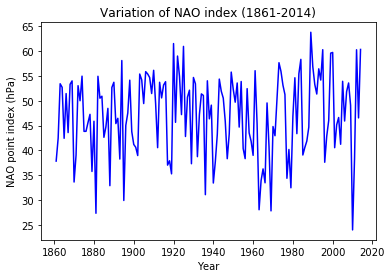

Total time: --- 3.75648593903 seconds ---


In [74]:
'''New version'''
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

start_time = tm.time()

a = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc")
b = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")
ps_inter = b.to_array()[0, :, :, :]
ds_ua850 = a.to_array()[0, :, 1:, :] #the 0th latitude gives nan values

#latss 65.68921234 - iceland 24 (old - 8)
#lonss 341.8875 - iceland 39 (old - 121)
#latss 37.78471054 - azores 24 (old - 18)
#lonss 334.35 - azores 22 (old - 119)

'''Defining useful terms'''
lat_ws_D = np.empty([154, 775])  
lat_ws_J = np.empty([154, 775])  
lat_ws_F = np.empty([154, 775])
winter_speeds = np.empty([154, 775, 128])

jet_strength = np.empty([154])
jet_latitude = np.empty([154])
NAO_index = np.empty([154])
header_param = "Year\t\tLatitude\tStrength\tNAO_index"

'''Winter mean NetCDF file'''
path = "/rds/general/user/ib719/home/UROP_2021/ws_winter.nc"
avg_ws = nc.Dataset(path, 'w', format = 'NETCDF4')
time = avg_ws.createDimension('time', 154)
lat = avg_ws.createDimension('lat', 775)
lon = avg_ws.createDimension('lon', 128)

times = avg_ws.createVariable('time', np.float32, ('time'))
lats = avg_ws.createVariable('lat', np.float32, ('lat'))
lons = avg_ws.createVariable('lon', np.float32, ('lon'))
value = avg_ws.createVariable('value', np.float32, ('time', 'lat', 'lon'))
value.units = 'm/s'
times[:] = np.arange(1861, 2015)
lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]

lat_ws_D[:, :] = np.mean(ds_ua850[119:1967:12, :, :], axis = 2) #1967 because 1968 is December
lat_ws_J[:, :] = np.mean(ds_ua850[120:1968:12, :, :], axis = 2) #should be 154
lat_ws_F[:, :] = np.mean(ds_ua850[121:1968:12, :, :], axis = 2) #should be 154

for i in range(10, 164): # Number of years from 1861 to 2014 
    value[i-10, :, :] = np.mean(ds_ua850[(12*i-1):(12*i+2), :, :], axis = 0)
    azores_ps = ps_inter[(12*i-1):(12*i+2), 449, 119] # Azores DJF
    iceland_ps = ps_inter[(12*i-1):(12*i+2), 199, 121] # Iceland DJF
    NAO_index[i-10] = np.average(azores_ps - iceland_ps)/100 # Division by 100 to convert into hPa
    jet_strength[i-10] = np.average([max(lat_ws_D[i-10]), max(lat_ws_J[i-10]), max(lat_ws_F[i-10])])
    # 1 is added to the index because the first latitude in latss is not used in lat_ws_D
    jet_latitude[i-10] = np.average([latss[np.where(lat_ws_D[i-10] == max(lat_ws_D[i-10]))[0][0]+1], \
                                     latss[np.where(lat_ws_J[i-10] == max(lat_ws_J[i-10]))[0][0]+1], \
                                     latss[np.where(lat_ws_F[i-10] == max(lat_ws_F[i-10]))[0][0]+1]])
    
avg_ws.close()
    
params = np.column_stack([ds_ws.time[120:1957:12].dt.year, jet_latitude, jet_strength, NAO_index])
np.savetxt('parameters.txt', params, fmt = '%.5f', delimiter = '\t', header = header_param, comments = '')
print('Parameters are saved')

plt.xlabel('Year')
plt.ylabel('NAO point index (hPa)')
plt.title('Variation of NAO index (1861-2014)')
plt.plot(np.arange(1861, 2015), NAO_index, color = 'blue')
plt.show()

print("Total time: --- %s seconds ---" % (tm.time() - start_time))

In [108]:
""" Regression Analysis """
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc

start_time = time.time()
c = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_winter.nc")
ds_avgws = c.to_array()[0, :, :, :]
years, jet_latitude, jet_strength, NAO_index = np.loadtxt("parameters.txt", skiprows = 1, unpack = True)
jet_strength_de = signal.detrend(jet_strength)
jet_latitude_de = signal.detrend(jet_latitude)
NAO_index_de = signal.detrend(NAO_index)

ws_transp = ds_avgws.transpose('lat', 'time', 'lon') #creating time series

''' Checking the plots '''
plt.xlabel('Year')
plt.ylabel('NAO point index (hPa)')
plt.title('Variation of NAO index (1861-2014)')
plt.plot(np.arange(1861, 2015), NAO_index, color = 'blue')
plt.show()

plt.xlabel('Year')
plt.ylabel('Jet Strength')
plt.title('Variation of jet strength  (1861-2014)')
plt.plot(np.arange(1861, 2015), jet_strength, color = 'blue')
plt.show()

plt.xlabel('Year')
plt.ylabel('Jet Latitude')
plt.title('Variation of Jet Latitude (1861-2014)')
plt.plot(np.arange(1861, 2015), jet_latitude, color = 'blue')
plt.show()

''' Nao Slopes Dataset '''
path = "/rds/general/user/ib719/home/UROP_2021/nao_slope.nc"
nao_slope = nc.Dataset(path, 'w', format = 'NETCDF4')
lat = nao_slope.createDimension('lat', 775)
lon = nao_slope.createDimension('lon', 128)

lats = nao_slope.createVariable('lat', np.float32, ('lat'))
lons = nao_slope.createVariable('lon', np.float32, ('lon'))
value = nao_slope.createVariable('value', np.float32, ('lat', 'lon'))
value.units = 'm/s/hPa'
lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]

#X should be M, Y should be M, K for polyfit 
for i in range(0, 775):
    value[i, :] = np.array(np.polyfit(NAO_index_de, ws_transp[i, :, :], 1)[0, :]) #check the shapes
    
nao_slope.close()

''' Lat Slopes Dataset '''
path = "/rds/general/user/ib719/home/UROP_2021/lat_slope.nc"
lat_slope = nc.Dataset(path, 'w', format = 'NETCDF4')
lat = lat_slope.createDimension('lat', 775)
lon = lat_slope.createDimension('lon', 128)

lats = lat_slope.createVariable('lat', np.float32, ('lat'))
lons = lat_slope.createVariable('lon', np.float32, ('lon'))
value = lat_slope.createVariable('value', np.float32, ('lat', 'lon'))
value.units = 'deg'

lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]

for i in range(0, 775):
    value[i, :] = np.array(np.polyfit(jet_latitude_de, ws_transp[i, :, :], 1)[0, :])
    
lat_slope.close()

'' 'Str Slopes Dataset '''
path = "/rds/general/user/ib719/home/UROP_2021/str_slope.nc"
str_slope = nc.Dataset(path, 'w', format = 'NETCDF4')
lat = str_slope.createDimension('lat', 775)
lon = str_slope.createDimension('lon', 128)

lats = str_slope.createVariable('lat', np.float32, ('lat'))
lons = str_slope.createVariable('lon', np.float32, ('lon'))
value = str_slope.createVariable('value', np.float32, ('lat', 'lon'))
value.units = 'm/s/deg'
lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]

for i in range(0, 775):
    value[i, :] = np.array(np.polyfit(jet_strength_de, ws_transp[i, :, :], 1)[0, :])
    
str_slope.close()

print("Indices are saved")

''' Averaging ws_winter time series '''
path = "/rds/general/user/ib719/home/UROP_2021/ua850_contour.nc"
cont = nc.Dataset(path, 'w', format = 'NETCDF4')
lat = cont.createDimension('lat', 775)
lon = cont.createDimension('lon', 128)

lats = cont.createVariable('lat', np.float32, ('lat'))
lons = cont.createVariable('lon', np.float32, ('lon'))
value = cont.createVariable('value', np.float32, ('lat', 'lon'))
value.units = 'm/s'
lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]
value[:, :] = np.mean(ds_avgws[:, :, :], axis = 0)

cont.close()
print("Speeds are time averaged")

print("--- %s seconds ---" % (time.time() - start_time))

Indices are saved
Speeds are time averaged
--- 5.74830698967 seconds ---


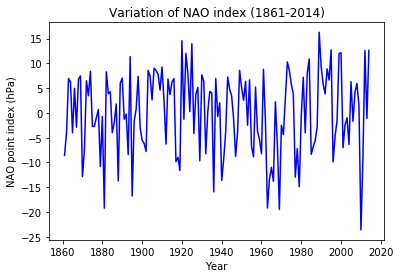

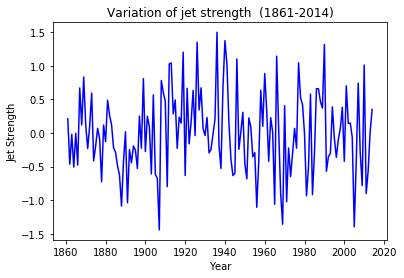

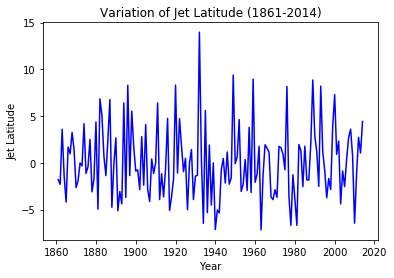

In [157]:
years, jet_latitude, jet_strength, NAO_index = np.loadtxt("parameters.txt", skiprows = 1, unpack = True)
jet_strength_de = signal.detrend(jet_strength)
jet_latitude_de = signal.detrend(jet_latitude)
NAO_index_de = signal.detrend(NAO_index)

''' Checking the plots '''
plt.xlabel('Year')
plt.ylabel('NAO point index (hPa)')
plt.title('Variation of NAO index (1861-2014)')
plt.plot(np.arange(1861, 2015), NAO_index_de, color = 'blue')
plt.show()

plt.xlabel('Year')
plt.ylabel('Jet Strength')
plt.title('Variation of jet strength  (1861-2014)')
plt.plot(np.arange(1861, 2015), jet_strength_de, color = 'blue')
plt.show()

plt.xlabel('Year')
plt.ylabel('Jet Latitude')
plt.title('Variation of Jet Latitude (1861-2014)')
plt.plot(np.arange(1861, 2015), jet_latitude_de, color = 'blue')
plt.show()

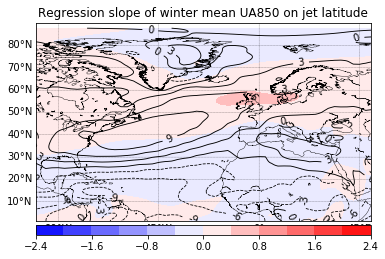

In [150]:
'''Plotting results'''
import os
#conda install basemap
os.environ["PROJ_LIB"] = "/rds/general/user/ib719/home/anaconda3/envs/test1/share/proj"
from mpl_toolkits.basemap import Basemap
ds_cont = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ua850_contour.nc")
ds_nao = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/nao_slope.nc")
ds_lat = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/lat_slope.nc")
ds_str = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/str_slope.nc")

map = Basemap(projection='cyl',llcrnrlon=-100.,llcrnrlat=1.39,urcrnrlon=50.0,urcrnrlat=90.,resolution='l') 
# projection, lat/lon extents and resolution of polygons to draw
# resolutions: c - crude, l - low, i - intermediate, h - high, f - full

map.drawcoastlines(linewidth = 0.4)
map.drawparallels(np.arange(10, 81, 10), labels = [1,0,0,0], linewidth = 0.3)
map.drawmeridians(np.arange(-90, 46, 45), labels = [0,0,0,1], linewidth = 0.3)
ua = np.array(ds_cont.value)
nao = np.array(ds_nao.value)
jet_strength = np.array(ds_str.value)
jet_latitude = np.array(ds_lat.value)

clevs = np.array([-9, -6, -3, 0, 3, 6, 9])
nao_levels = np.arange(-0.6, 0.7, 0.1)
strength_levels = np.arange(-1.2, 1.4, 0.2)
latitude_levels = np.arange(-2.4, 2.8, 0.4)
lines = ['dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid']
cols = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
width = [0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9]
x, y = np.meshgrid(ds_ws.lon[:], latss[1:])

#cs = map.contour(x, y, np.roll(ua[:, :], shift = -1600, axis = 1), clevs, colour = 'b') #should be with x -180?
cs1 = map.contour(x, y, ua[:, :], clevs, colors = cols, linestyles = lines, linewidths = width, latlon = 1)
plt.clabel(cs1, fontsize=10, inline=2, fmt = '%.f')
#cs2 = map.contourf(x, y, nao[:, :], nao_levels, cmap = 'bwr', latlon = 1)
#cs3 = map.contourf(x, y, jet_strength[:, :], strength_levels, cmap = 'bwr', latlon = 1)
cs4 = map.contourf(x, y, jet_latitude[:, :], latitude_levels, cmap = 'bwr', latlon = 1)
cbar = map.colorbar(cs4, 'bottom')
#cbar.set_label('m/s/$\deg$')
plt.title('Regression slope of winter mean UA850 on jet latitude')
plt.savefig("ua850_latitude.png", dpi = 250)

#colors = 'coolwarm'


[ -1.98236197e-01  -1.94824517e-01  -1.91446736e-01  -1.88092306e-01
  -1.84750736e-01  -1.81411475e-01  -1.78064108e-01  -1.74698040e-01
  -1.71302840e-01  -1.67867988e-01  -1.64382949e-01  -1.60837233e-01
  -1.57220379e-01  -1.53521821e-01  -1.49731100e-01  -1.45837694e-01
  -1.41831130e-01  -1.37700871e-01  -1.33436412e-01  -1.29027277e-01
  -1.24462970e-01  -1.19732954e-01  -1.14826731e-01  -1.09733827e-01
  -1.04443736e-01  -9.89148617e-02  -9.31773633e-02  -8.72328058e-02
  -8.10827017e-02  -7.47286528e-02  -6.81721568e-02  -6.14147671e-02
  -5.44580221e-02  -4.73034903e-02  -3.99526916e-02  -3.24071981e-02
  -2.46685352e-02  -1.67382639e-02  -8.61791614e-03  -3.09049065e-04
   8.18681251e-03   1.68680679e-02   2.57332530e-02   3.47807780e-02
   4.40090895e-02   5.34166582e-02   6.30019233e-02   7.27633610e-02
   8.26994181e-02   9.28085223e-02   1.03096731e-01   1.13518164e-01
   1.24034055e-01   1.34605721e-01   1.45194337e-01   1.55761212e-01
   1.66267544e-01   1.76674649e-01